## Logic Based Shield - Large Map with Dyna-Q in Frozenlake Environment

In [2]:
import gymnasium
import time
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
from gym.envs.toy_text.frozen_lake import generate_random_map

In [19]:
# Generate a random map of size n=10 with hole probability of 1-p.
random_map = generate_random_map(size=10, p=0.85)
for i in random_map:
    print(i)

SFHFFFFFFF
FFFFHFFFFH
FFFFHFFFFF
FFFFFFFFFF
FFFFFFFFFH
FFFFFFFFFF
FFHFFHFFFF
FFFHFFFFFF
HFHFFFHFFH
HHFFFFHFFG


In [5]:
def get_coordinates(state, grid_size):
    """Function to get coordinates from state.
       Takes in a state and a grid size and returns the row and column in x, y coordinates.
       These start at the top left at 0, 0, where the agent begins."""
    col = state % grid_size
    row = state // grid_size
    return row, col

# Test for get_coordinates function.
print(get_coordinates(12, 8))

def get_state(x, y, grid_size):
    """Function to get state from coordinates.
       Takes in row and column (x, y) coordinates and a grid size and returns the state.
       state = row * ncols + current_col"""
    return x * grid_size + y

# Test for get_state function.
print(get_state(1, 4, 8))

(1, 4)
12


###### Fact Generator

In [6]:
def fact_generator(state, action, new_state, grid_size):
    """Function to generate facts from state transitions."""
    actions = {0: "left", 1: "down", 2: "right", 3:"up"}
    
    # Get coordinates for state and new state and differences between them.
    old_x, old_y = get_coordinates(state, grid_size)
    new_x, new_y = get_coordinates(new_state, grid_size)
    x_dif = new_x - old_x
    y_dif = new_y - old_y

    # Create x,y change fact.  0=left, 1=down, 2=right, 3=up
    if x_dif != 0:
        fact = [action, ((x_dif, y_dif), "If " + actions[action] + " action taken then x changes by " + str(x_dif))]
    elif y_dif != 0:
        fact = [action, ((x_dif, y_dif), "If " + actions[action] + " action taken then y changes by " + str(y_dif))]
    else:
        fact = [action, ((x_dif, y_dif), "If " + actions[action] + " action taken there is no positional change")]
    
    return fact

In [40]:
# Test for fact_generator function. Parameters: state, action, new_state, grid_size
print(fact_generator(20, 0, 19, 8))

[0, ((0, -1), 'If left action taken then y changes by -1')]


###### Fact Storage

In [7]:
class Facts():
    """Class to hold facts generated.
    Facts are in format [(x_id, y_dif), "Fact string"]
    self.facts is a list with a dictionary in each index corresonding to the actions  0=left, 1=down, 2=right, 3=up
    Each dictionary has the facts as the keys and the count of the times they have occured as the value."""
    
    def __init__(self):
        # Dictionary to hold facts e.g 1: 2, "If up action taken then y changes by 1"
        # Nested dictionaries to hold facts for each corresponding action.
        self.facts = [{}, {}, {},{}]
    
    def add_fact(self, fact):
        # Add fact to database.
        if fact[1] in self.facts[fact[0]]:
            # Increment fact count if already in the action dictionary.
            self.facts[fact[0]][fact[1]] += 1
        else:
            # Add the fact to the action dictionary with value of 1.
            self.facts[fact[0]][fact[1]] = 1
        
    def most_probable_effect(self, action):
        # return most probable outcome for a given outcome.
        return max(self.facts[action].keys(), key=(lambda key: self.facts[action][key]))[0]

    def __str__(self):
        actions = {0: "left", 1: "down", 2: "right", 3:"up"}
        for ind, a in enumerate(self.facts):
            print(actions[ind])
            for f in a:
                print("    " + str(f) + " Count: " + str(a[f]))
    
    def actions_probabilites(self, action):
        # Return list of facts with counts and probabilities for an action
        total = sum([self.facts[action][k] for k in self.facts[action]])
        print(total)
        for k in self.facts[action]:
            print(k[1], ": ", round(self.facts[action][k]/total*100, 1),"%")

In [42]:
storage = Facts()
fact_1 = fact_generator(4, 0, 3, 8)
fact_2 = fact_generator(4, 0, 2, 8)
print("Facts to be added")
print(fact_1)
print(fact_2)
storage.add_fact(fact_1)
storage.add_fact(fact_1)
storage.add_fact(fact_2)
storage.add_fact(fact_2)
storage.add_fact(fact_2)
print("Test for __str__() function.")
storage.__str__()
print("Test for storage.most_probable_effect(0)")
print(storage.most_probable_effect(0))
print()
storage.actions_probabilites(0)

Facts to be added
[0, ((0, -1), 'If left action taken then y changes by -1')]
[0, ((0, -2), 'If left action taken then y changes by -2')]
Test for __str__() function.
left
    ((0, -1), 'If left action taken then y changes by -1') Count: 2
    ((0, -2), 'If left action taken then y changes by -2') Count: 3
down
right
up
Test for storage.most_probable_effect(0)
(0, -2)

5
If left action taken then y changes by -1 :  40.0 %
If left action taken then y changes by -2 :  60.0 %


###### Function to predict next state based on most probable action effect

In [8]:
def predicted_state(current_state, effect, grid_size):
    """Function to take in current state and predicted effect on coordinates.
        Applies predicted x, y change to the state and returns it.
        Error checking as min x, y is 0, 0 and max is grid_size - 1, grid_size - 1."""
    x, y = get_coordinates(current_state, grid_size)
    new_x, new_y = min(max(0, x + effect[0]), grid_size - 1), min(max(0, y + effect[1]), grid_size - 1)
    
    return get_state(new_x, new_y, grid_size)

In [44]:
print(predicted_state(11, (1, 0), 8))

19


###### Class to store unsafe states

In [9]:
class Unsafe_states:
    """Class to hold list of unsafe states"""
    def __init__(self):
        self.states = [] # List of unsafe states.
    
    def add_state(self, state):
        # Add state as long as not already in list.
        if state not in self.states:
            self.states.append(state)
        
    def is_unsafe(self, state):
        # Check if state is unsafe.
        if state in self.states:
            return True
        else:
            return False
        
    def how_many(self):
        return len(self.states)

    def __str__(self):
        return f"Unsafe states: {sorted(self.states)}"

In [46]:
unsafe = Unsafe_states()
unsafe.add_state(56)
unsafe.add_state(5)
unsafe.add_state(6)

print("Tests for Unsafe_states() class functions:")
print(unsafe.is_unsafe(6))
print(unsafe.is_unsafe(7))
print(unsafe.how_many())
print(unsafe.__str__())

Tests for Unsafe_states() class functions:
True
False
3
Unsafe states: [5, 6, 56]


###### Statistics functions

In [10]:
def sum_rewards(reward_per_episode, episodes_completed):
    """Returns the reward for last 100 episodes for each episode, to give the success rate of the algorithm.
       The maximum is 100, so a 0-100 scale is created, with 100 being the perfect score."""
    sum_of_rewards = np.zeros(episodes_completed)
    for i in range(episodes_completed):
        # Rewards for last 100 episodes.
        sum_of_rewards[i] = np.sum(reward_per_episode[max(0, i - 100):(i+1)])
    return sum_of_rewards

def cumulative_reward(rewards_per_episode):
    """Create a list of the cumulative reward the agent has gained per episode."""
    cumulative_reward = [rewards_per_episode[0]]
    for i in rewards_per_episode[1:]:
        cumulative_reward.append(i + cumulative_reward[-1])
    return cumulative_reward

In [20]:
class memory_buffer:
    """Class for the memory buffer for Dyna-Q. Initialised with batch size and storage values."""
    def __init__(self, batch_size=64, max_storage=1000000):
        self.memory = deque([])
        self.batch_size = batch_size
        self.storage_cap = max_storage
    
    def add_memory(self, new_memory):
        """Function to add a (s,a,r,s) tuple to the memory buffer.
           If the memory buffer is at capacity, delete a memory."""
        if len(self.memory) >= self.storage_cap:
            # Memory from left of deque is deleted, new one added.
            self.memory.popleft()
            self.memory.append(new_memory)
        else:
            # New memory added.
            self.memory.append(new_memory)
    
    def fetch_batch(self):
        """Returns a list of the batch size number of samples."""
        return random.sample(self.memory, self.batch_size)

Number of steps taken 532160, Violations: 52
Number of steps taken 475138, Violations: 659
Number of steps taken 531555, Violations: 53
Number of steps taken 531972, Violations: 51
Number of steps taken 482417, Violations: 678
Number of steps taken 531261, Violations: 44
Number of steps taken 533028, Violations: 65
Number of steps taken 542492, Violations: 113
Number of steps taken 475763, Violations: 651
Number of steps taken 474042, Violations: 651
With shield
Elapsed time is 5481.08 seconds.
Average violations per run:  301.7
Number of steps taken 459409, Violations: 3804
Number of steps taken 458705, Violations: 2886
Number of steps taken 469373, Violations: 7404
Number of steps taken 466095, Violations: 7288
Number of steps taken 455567, Violations: 2946
Number of steps taken 467823, Violations: 7343
Number of steps taken 470323, Violations: 8511
Number of steps taken 457306, Violations: 3497
Number of steps taken 457374, Violations: 3852
Number of steps taken 460136, Violations: 

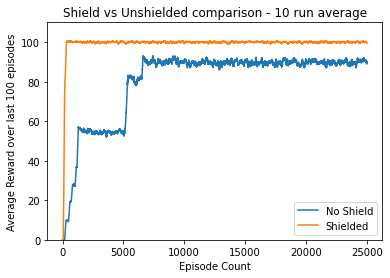

In [21]:
def frozen_lake(episodes, shield=False, the_grid_size=8, render=False):
    env = gymnasium.make("FrozenLake-v1", desc=random_map, is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    grid_size = the_grid_size
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
    epsilon = 0.05 # The e-greedy randomisation starting rate.
    decay = 0.001  # Decay rate of epsilon each episode
    discount = 0.9
    learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
    
    # Statistic variables
    steps = 0
    episodes_completed = 0
    violations = 0
    
    reward_per_episode = [] # List to track reward for each episode.
    unsafe_states = Unsafe_states() # Unsafe states tracker
    storage = Facts() # Fact storage
    
    replay_experience = memory_buffer()
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0
        moves = 0 # Number of actions agent has taken in each episode
        
        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state]):
                if shield:                    
                    # Next best actions: A list of the best actions in order of descending q-value.
                    random_action = False
                    next_best_actions = list(np.argsort(q_table[state]))[::-1]
                else:
                    # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                    action = np.argmax(q_table[state])
                steps += 1 # Increment step counter
                moves += 1
            else:
                # Random action
                random_action = True
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter
                moves += 1
            
            if shield and i > 5:
                # If shield is active, check if the action is predicted to unsafe state.
                if random_action:
                    # Next best actions are the chosen action then the other three randomised
                    pos = [0,1,2,3]
                    pos.remove(action)
                    random.shuffle(pos)
                    # One action available, which is the random one if random action taken.
                    next_best_actions = [action] + pos
                
                action = None
                # Check that the actions are safe and let the highest q-value action pass.
                for a in next_best_actions:
                    # Predict next state based on effect of action.
                    effect = storage.most_probable_effect(a) # Most probable effect for action
                    
                    pred_state = predicted_state(state, effect, grid_size) # Predicted state given effect
                    
                    # Check if state that action is predicted to lead to is in unsafe_states storage.
                    if not unsafe_states.is_unsafe(pred_state):
                        action = a
                        break
                
                # If no action is deemed safe, take a random action
                if action == None:
                    # Take random action
                    posssible = [0,1,2,3]
                    posssible.remove(next_best_actions[0])
                    action = random.choice(posssible)
            
            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # Add memory to the memory buffer.
            replay_experience.add_memory((state, action, reward, new_state)) # Check if bracket are redundant
            
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # Generate fact and add to fact storage.
            fact = fact_generator(state, action, new_state, grid_size)
            storage.add_fact(fact)
            
            # New state becomes current state.
            state = new_state
            
            if i > 50:
                # Update q-tables from batch from memory buffer.
                for m in replay_experience.fetch_batch():
                    d_state, d_action, d_reward, d_new_state = m # Split out tuple then update q-tabel with memory.
                    q_table[d_state, d_action] = (1 - learning_rate) * q_table[d_state, d_action] + learning_rate * (d_reward + discount * np.max(q_table[d_new_state, :]))

        # Track reward
        reward_per_episode.append(reward)
        
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) means that a violation has happened.
            # Add unsafe state to database.
            unsafe_states.add_state(state) 
            violations += 1
            
        env.close()
        episodes_completed += 1
    
    print(f"Number of steps taken {steps}, Violations: {violations}")
    
    return sum_rewards(reward_per_episode, episodes_completed), violations

training_episodes = 25000
training_runs = 10

""" ***** With Shield ***** """
t1 = time.time() # Start timer
all_rewards = []
all_violations = []
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes, shield=True, the_grid_size=12) # Parameters: episodes, shield=False, grid_size=8
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print("With shield")
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

# Generate stats
average_rewards_shield = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_shield.append(total/training_runs)

""" ***** Without Shield ***** """
t1 = time.time() # Start timer
all_rewards = []
all_violations = []
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes, the_grid_size=10) # Parameters: episodes, shield=False, grid_size=8
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print("Without shield")
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

# Generate stats
average_rewards = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards.append(total/training_runs)

# Plot results
plt.title("Shield vs Unshielded comparison - 10 run average")
plt.plot(average_rewards, label="No Shield")
plt.plot(average_rewards_shield, label="Shielded")
plt.ylim(0, 110)
plt.xlabel("Episode Count")
plt.ylabel("Average Reward over last 100 episodes")
plt.legend(loc="lower right")
plt.show()

### Catastrophic Action Shield for comparison

In [22]:
class catastrophy_shield:
    def __init__(self, actions):
        self.catastrophies = {}
        self.actions = actions
        
    def add_catastrophy(self, state, action):
        if state not in self.catastrophies:
            # If this state is not in dictionary, add it, with action in a list.
            self.catastrophies[state] = [action]
        elif action not in self.catastrophies[state]:
            # If state is in the dictionary, but action is not in the state, add it.
            self.catastrophies[state].append(action)
        else:
            pass
    
    def is_state_action_safe(self, state, action):
        # Checks if an action is safe. Returns True if it is, False if it is not.
        if state in self.catastrophies and action in self.catastrophies[state]:
            return False
        return True
    
    def unsafe_actions_in_state(self, state):
        # Checks which actions are unsafe in a state. Returns 
        if state in self.catastrophies:
            return self.catastrophies[state]
        else:
            raise Exception("State not in catastrophies dictionary")
    
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", desc=random_map, is_slippery=False, render_mode="human" if render else None) 
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.05 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
        actions = [0,1,2,3] # Actions the agent may take
        shield = catastrophy_shield(actions)
        
    reward_per_episode = []
    
    replay_experience = memory_buffer()
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon and any(q_table[state, :]):
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter
            
            # Shield checks action
            safe = shield.is_state_action_safe(state, action)
            if safe:
                # No further action needed
                pass
            else:
                unsafe_actions = shield.unsafe_actions_in_state(state)
                # Get actions in q-table ranked and choose highest safe option.
                potential_actions = []
                for i in actions:
                    if i not in unsafe_actions:
                        potential_actions.append([q_table[state][i], i])
                # The action of the potential action with highest q_value, random if all values are 0.
                if len(potential_actions) == 0:
                    # If no safe actions available, do unsafe action regardless.
                    pass
                else:
                    if max(potential_actions)[0] == 0:
                        action = random.choice(potential_actions)[1]
                    else:
                        action = max(potential_actions)[1]
            
            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # Add memory to the memory buffer.
            replay_experience.add_memory((state, action, reward, new_state)) # Check if bracket are redundant
            
            # If action resulted in a catastrophy, add it to the shield.
            if terminated and reward != 1:
                shield.add_catastrophy(state, action)
            
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (float(reward) + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state

            if i > 50:
                # Update q-tables from batch from memory buffer.
                for m in replay_experience.fetch_batch():
                    d_state, d_action, d_reward, d_new_state = m # Split out tuple then update q-tabel with memory.
                    q_table[d_state, d_action] = (1 - learning_rate) * q_table[d_state, d_action] + learning_rate * (d_reward + discount * np.max(q_table[d_new_state, :]))


        # Decrease epsilon after each episode to min of 0.01.
        #epsilon = max(epsilon - decay, 0.01)

        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations
    # return reward_per_episode, violations

t1 = time.time() # Start timer
all_rewards = []
all_violations = []
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_ca = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_ca.append(total/training_runs)

Number of steps taken 479342, Violations: 42
Number of steps taken 493054, Violations: 42
Number of steps taken 480369, Violations: 40
Number of steps taken 474807, Violations: 39
Number of steps taken 477119, Violations: 40
Number of steps taken 481822, Violations: 40
Number of steps taken 480820, Violations: 40
Number of steps taken 476058, Violations: 36
Number of steps taken 480172, Violations: 38
Number of steps taken 482220, Violations: 41
Elapsed time is 4628.51 seconds.
Average violations per run:  39.8


In [23]:
def frozen_lake(episodes, render=False, training=True):
    env = gymnasium.make("FrozenLake-v1", desc=random_map, is_slippery=False, render_mode="human" if render else None) 
    actions = [0,1,2,3] # Actions the agent may take
    if training:
        q_table = np.zeros((env.observation_space.n, env.action_space.n))  # 64 states, 4 actions
        epsilon = 0.05 # The e-greedy randomisation starting rate.
        decay = 0.001  # Decay rate of epsilon each episode
        discount = 0.9
        learning_rate = 0.9 # Learning rate (new_q = (1- lr)*old_q + (lr)*new_q)
        
        # Statistic variables
        steps = 0
        episodes_completed = 0
        violations = 0
        
    reward_per_episode = []
    
    replay_experience = memory_buffer()
    
    for i in range(episodes):
        state = env.reset()[0]  # Top left is where person will be ([0])
        terminated = False  # True is falls in hole or reaches goal
        truncated = False  # True if actions goes over 200
        reward = 0

        while not terminated and not truncated:
            if random.uniform(0, 1) > epsilon: # and any(q_table[state, :])
                # Do the q-table action if one is available (if all q_table values are 0, no action is better than any other.)
                action = np.argmax(q_table[state, :])
                steps += 1 # Increment step counter
            else:
                # Random action
                action = env.action_space.sample() # # 0=left, 1=down, 2=right, 3=up
                steps += 1 # Increment step counter

            # Take action
            new_state, reward, terminated, truncated, info = env.step(action)
            
            # Add memory to the memory buffer.
            replay_experience.add_memory((state, action, reward, new_state)) # Check if bracket are redundant
            
            """Intrinsic Punishemnt: Penalty given if unsafe action taken."""
            if terminated and reward != 1:
                # Penalty if an unsafe action is taken.
                reward = -0.1
            elif reward != 1:
                # Small negative reward for each step taken that is not a reward or unsafe action.
                # Without this the agent does not reach the goal, as unsafe actions propagate negative rewards.
                reward = -0.01
                
            # Update q-table
            q_table[state, action] = (1 - learning_rate) * q_table[state, action] + learning_rate * (reward + discount * np.max(q_table[new_state, :]))
            
            # New state becomes current state.
            state = new_state
            
            if i > 50:
                # Update q-tables from batch from memory buffer.
                for m in replay_experience.fetch_batch():
                    d_state, d_action, d_reward, d_new_state = m # Split out tuple then update q-tabel with memory.
                    q_table[d_state, d_action] = (1 - learning_rate) * q_table[d_state, d_action] + learning_rate * (d_reward + discount * np.max(q_table[d_new_state, :]))


        # Decrease epsilon after each episode to min of 0.02.
        #epsilon = max(epsilon - decay, 0.02)
        
        # Track reward
        reward_per_episode.append(reward)
        if reward != 1 and not truncated:
            # No reward and not truncated (too many actions taken) menas that a violation has happened.
            # The length of the episode is 100 for 4x4 environment, 200 for 8x8 environment.
            violations += 1

        env.close()
        episodes_completed += 1
        
    print(f"Number of steps taken {steps}, Violations: {violations}")
                  
    return sum_rewards(reward_per_episode, episodes_completed), violations

t1 = time.time() # Start timer
all_rewards = []
all_violations = []
for i in range(training_runs):
    rewards, violations = frozen_lake(training_episodes)
    all_rewards.append(rewards)
    all_violations.append(violations)
t2 = time.time() # Stop timer
time_taken = t2 - t1 # Time taken
print(f'Elapsed time is {time_taken:.2f} seconds.')
print("Average violations per run: ", sum(all_violations)/training_runs)

average_rewards_pen = []
for i in range(training_episodes):
    # Sum the runs and divide by number of runs to get the mean.
    total = sum([j[i] for j in all_rewards])
    average_rewards_pen.append(total/training_runs)

Number of steps taken 465296, Violations: 1900
Number of steps taken 465130, Violations: 1905
Number of steps taken 464884, Violations: 1523
Number of steps taken 464251, Violations: 1678
Number of steps taken 463994, Violations: 1689
Number of steps taken 464790, Violations: 1613
Number of steps taken 464679, Violations: 1599
Number of steps taken 463843, Violations: 1725
Number of steps taken 464144, Violations: 1630
Number of steps taken 463608, Violations: 1640
Elapsed time is 4640.68 seconds.
Average violations per run:  1690.2


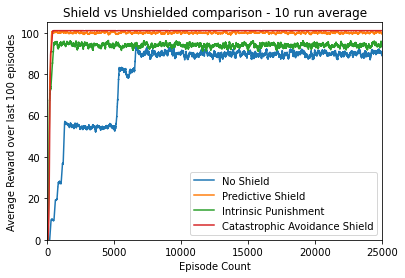

In [31]:
# Plot results
plt.title("Shield vs Unshielded comparison - 10 run average")
plt.plot(average_rewards, label="No Shield")
plt.plot(average_rewards_shield, label="Predictive Shield")
plt.plot(average_rewards_pen, label="Intrinsic Punishment")
plt.plot(average_rewards_ca, label="Catastrophic Avoidance Shield")
# plt.ylim(0, 110)
plt.axis([0, 25000, 0, 105])
plt.xlabel("Episode Count")
plt.ylabel("Average Reward over last 100 episodes")
plt.legend(loc="lower right")
plt.show()

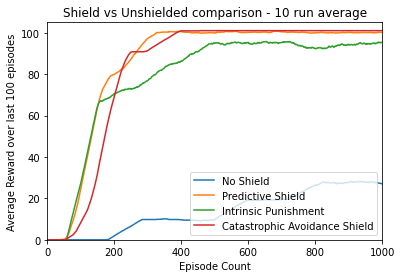

In [29]:
# Plot results
plt.title("Shield vs Unshielded comparison - 10 run average")
plt.plot(average_rewards, label="No Shield")
plt.plot(average_rewards_shield, label="Predictive Shield")
plt.plot(average_rewards_pen, label="Intrinsic Punishment")
plt.plot(average_rewards_ca, label="Catastrophic Avoidance Shield")
plt.axis([0, 1000, 0, 105]) # [x_min, x_max, y_min, y_max]
plt.xlabel("Episode Count")
plt.ylabel("Average Reward over last 100 episodes")
plt.legend(loc="lower right")
plt.show()